<a href="https://colab.research.google.com/github/Adrianus-Bagas/Face-Mask-Detection/blob/main/Face_Mask_Detection_(Training).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deteksi Orang Bermasker

## 1. Import beberapa libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import *

## 2. Memuat data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
disease_types=['without mask','with mask']
data_dir = '/content/drive/MyDrive/dataset/Masker/'
dir = os.path.join(data_dir)

In [ ]:
data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(dir, sp)):
        data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
df = pd.DataFrame(data, columns=['File', 'Label','Masker'])
df

,File,Label,Masker
0,without mask/270.jpg,0,without mask
1,without mask/187.jpg,0,without mask
2,without mask/129.jpg,0,without mask
3,without mask/augmented_image_197.jpg,0,without mask
4,without mask/55.jpg,0,without mask
...,...,...,...
1367,with mask/augmented_image_0.jpg,1,with mask
1368,with mask/295-with-mask.jpg,1,with mask
1369,with mask/129-with-mask.jpg,1,with mask
1370,with mask/375-with-mask.jpg,1,with mask


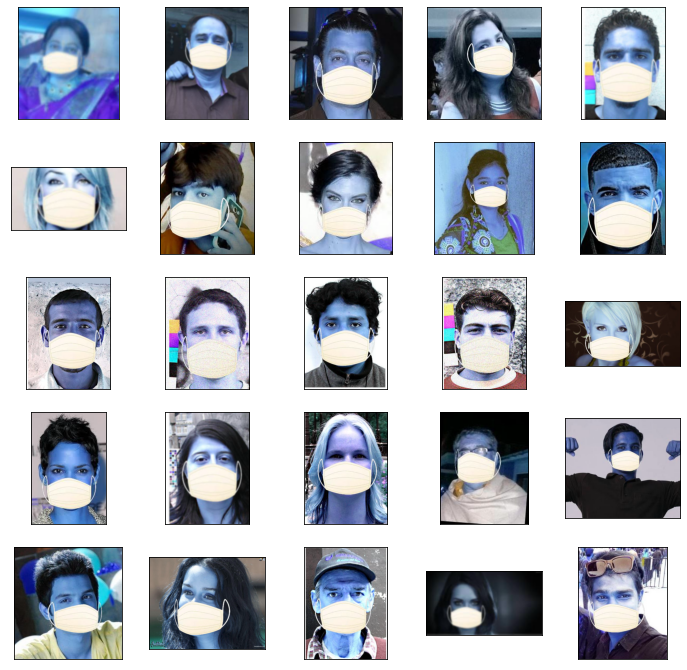

In [ ]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = df['File'][df['Masker'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('with mask', 5, 5)

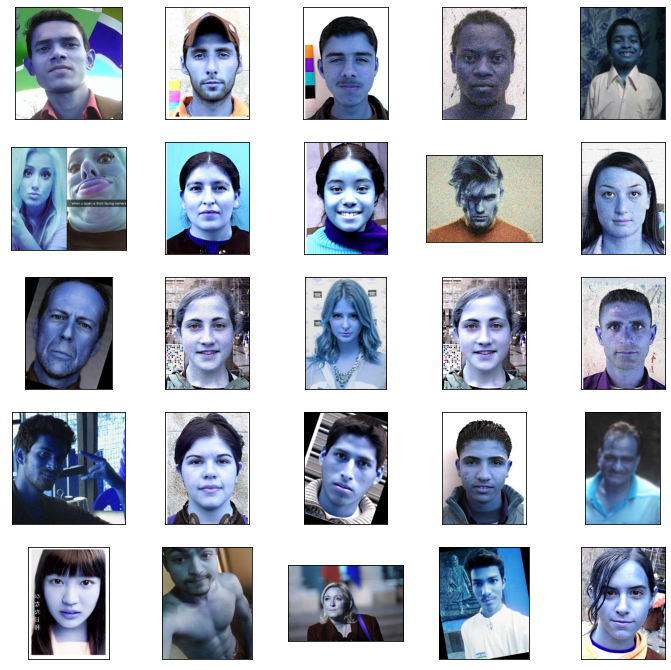

In [ ]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = df['File'][df['Masker'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('without mask', 5, 5)

## 3. Image Preprocessing

In [ ]:
IMAGE_SIZE = 100
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [ ]:
X = []
for i, file in tqdm(enumerate(df['File'].values)):
    image = read_image(file)
    if image is not None:
        gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        resized = resize_image(gray, (IMAGE_SIZE, IMAGE_SIZE))
        X.append(resized)

1372it [00:10, 130.24it/s]


In [ ]:
X=np.array(X)/255.0
X=np.reshape(X,(X.shape[0],IMAGE_SIZE,IMAGE_SIZE,1))
X.shape

(1372, 100, 100, 1)

In [ ]:
Y = df['Label'].values
Y = to_categorical(Y, num_classes=2)

In [ ]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# 4. Model CNN

In [ ]:
model=Sequential()

model.add(Conv2D(64,(3,3),activation='relu',input_shape=(100,100,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.2))

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.2))

model.add(Conv2D(16,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.2))

model.add(Conv2D(8,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(4,activation='relu'))
model.add(Dense(2,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.002),metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 16)       0

In [ ]:
# Fits the model on batches with real-time data augmentation
hist = model.fit(X_train, Y_train, batch_size=128, epochs=12, validation_data=(X_val, Y_val))

Epoch 1/12
9/9 [==============================] - 8s 147ms/step - loss: 0.6928 - accuracy: 0.5305 - val_loss: 0.6891 - val_accuracy: 0.5709
Epoch 2/12
9/9 [==============================] - 1s 65ms/step - loss: 0.6871 - accuracy: 0.5716 - val_loss: 0.6734 - val_accuracy: 0.6109
Epoch 3/12
9/9 [==============================] - 1s 65ms/step - loss: 0.6663 - accuracy: 0.6153 - val_loss: 0.6410 - val_accuracy: 0.6400
Epoch 4/12
9/9 [==============================] - 1s 65ms/step - loss: 0.6310 - accuracy: 0.6335 - val_loss: 0.6047 - val_accuracy: 0.6400
Epoch 5/12
9/9 [==============================] - 1s 65ms/step - loss: 0.6046 - accuracy: 0.6536 - val_loss: 0.5835 - val_accuracy: 0.6727
Epoch 6/12
9/9 [==============================] - 1s 65ms/step - loss: 0.5629 - accuracy: 0.7065 - val_loss: 0.5230 - val_accuracy: 0.7309
Epoch 7/12
9/9 [==============================] - 1s 66ms/step - loss: 0.4879 - accuracy: 0.7758 - val_loss: 0.3910 - val_accuracy: 0.8473
Epoch 8/12
9/9 [==========

In [ ]:
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

9/9 [==============================] - 0s 8ms/step - loss: 0.2613 - accuracy: 0.8909
Final Loss: 0.26130640506744385, Final Accuracy: 0.8909090757369995


Text(0.5, 145.31999999999996, 'Predicted')

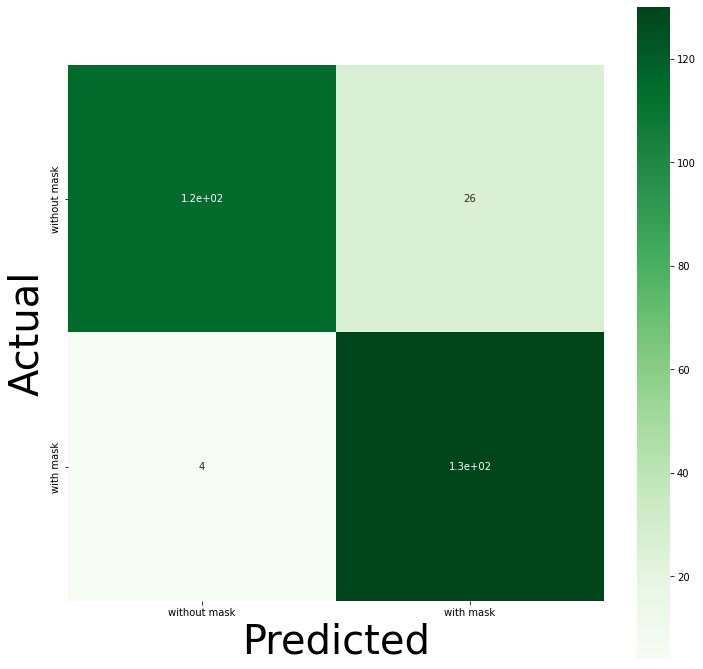

In [ ]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

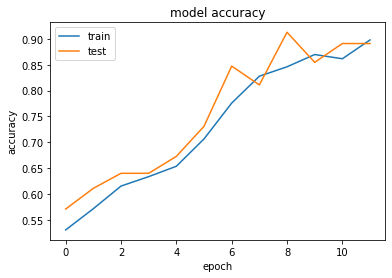

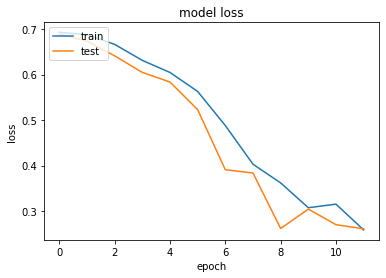

In [ ]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# from skimage import io
# from keras.preprocessing import image
# #path='imbalanced/Scratch/Scratch_400.jpg'
# img = image.load_img('/content/drive/MyDrive/dataset/data COVID/COVID/Covid (56).png', grayscale=False, target_size=(64, 64))
# show_img=image.load_img('/content/drive/MyDrive/dataset/data COVID/COVID/Covid (56).png', grayscale=False, target_size=(200, 200))
# disease_class=['Non Covid-19','Covid-19']
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis = 0)
# x /= 255

# custom = model.predict(x)
# print(custom[0])

# plt.imshow(show_img)
# plt.show()

# a=custom[0]
# ind=np.argmax(a)
        
# print('Prediction:',disease_class[ind])

In [ ]:
# model.save('model densenet.h5')

In [ ]:
# X_val.shape

In [ ]:
# cm = confusion_matrix(Y_true, Y_pred)
# cm

In [ ]:
# model.save('/content/drive/MyDrive/model/model masker.h5')